In [1]:
import numpy as np 
import pandas as pd 
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from os import listdir
from os.path import isfile, join
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Input,Lambda
from keras.utils import to_categorical
from keras.applications.resnet import ResNet50, preprocess_input
from keras.models import Model
from PIL import Image
import imutils
from tqdm import tqdm

In [2]:
def crop_img(img):
    # Find the extreme points and take a reactangle out of them
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # colored to grayscale image
    gray = cv2.GaussianBlur(gray, (3, 3), 0) # to reduce noise in the image

    # find contours in thresholded image, then grab the largest one
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations=2)
    thres = cv2.dilate(thres, None, iterations=2)
    # we usually want the focused part to be white for it to be detected correctly
    # Image contouring is process of identifying structural outlines of objects for better detection
    cntrs = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # image, contour retrieval method and contour approximation
    cntrs = imutils.grab_contours(cntrs) # actually obtain the contours
    c = max(cntrs, key=cv2.contourArea) # obtain the largest contour
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise

    # Now that we have obtained the largest contour of an image, we must determine the extreme points
    # find the extreme points

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # adding the contour on image
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

    # adding the extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # crop
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

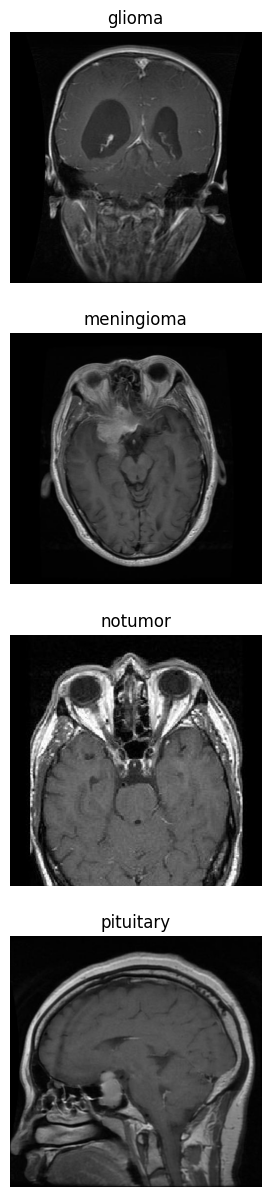

In [3]:
dirs=('Training')
categories=['glioma', 'meningioma', 'notumor','pituitary']
plt.figure(figsize=(10,15))
img_path=['/glioma/Tr-gl_0015.jpg', '/meningioma/Tr-meTr_0005.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-pi_0026.jpg']


for i in range(0, 4):
    ax=plt.subplot(4, 1, i + 1)
    img=cv2.imread(dirs + img_path[i])
    new_img=crop_img(img)
    plt.imshow(img)
    plt.axis('off')
    plt.title(categories[i])

In [4]:
img = cv2.imread('Training/meningioma/Tr-meTr_0000.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

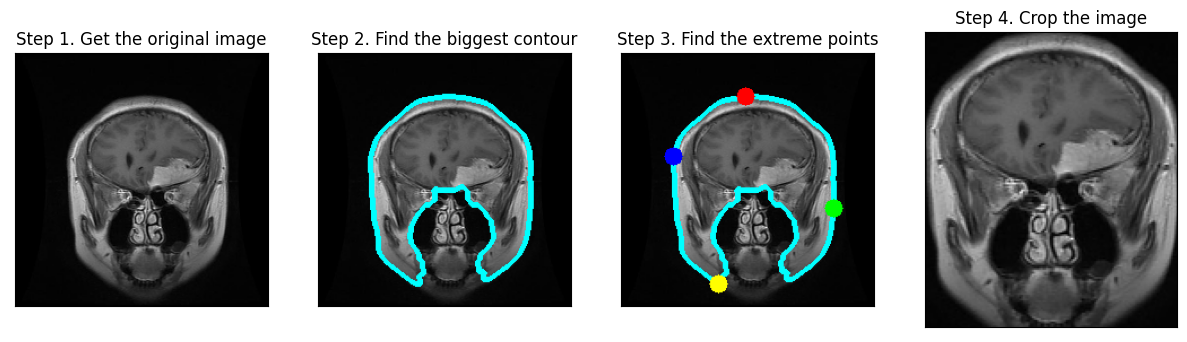

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [8]:

training='Training'

training_dir=os.listdir(training)

img_size=200

for dir in training_dir:
    save_path=training + '/cropped/' + dir
    path=os.path.join(training, dir)
    image_dir=os.listdir(path)
    for img in image_dir:
        image=cv2.imread(os.path.join(path, img))
        new_img=crop_img(image)
        new_img=cv2.resize(new_img, (img_size, img_size))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)

In [6]:
labels = ['glioma', 'meningioma', 'notumor','pituitary']

x = [] # training images.
y  = [] # training labels.

image_size = 150


for label in labels:
    trainPath = os.path.join('Training/cropped', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x.append(image)
        y.append(labels.index(label))

100%|██████████| 1457/1457 [00:03<00:00, 423.43it/s]


In [14]:
testing='Testing'

testing_dir=os.listdir(testing)

img_size=200

for dir in testing_dir:
    save_path=testing + '/cropped/' + dir
    path=os.path.join(testing, dir)
    image_dir=os.listdir(path)
    for img in image_dir:
        image=cv2.imread(os.path.join(path, img))
        new_img=crop_img(image)
        new_img=cv2.resize(new_img, (img_size, img_size))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)

In [11]:
labels = ['glioma', 'meningioma', 'notumor','pituitary']

xt = [] 
yt  = [] 
image_size = 150


for label in labels:
    testPath = os.path.join('Testing/cropped', label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        xt.append(image)
        yt.append(labels.index(label))

100%|██████████| 300/300 [00:00<00:00, 587.72it/s]


In [12]:
x_train, x_test, y_train, y_test = x, xt, y, yt
x_valid, y_valid = x_test, y_test

In [13]:
x_train=np.array(x_train)
x_train = (x_train.astype('float32') )/ 255
x_test=np.array(x_test)
x_test = (x_test.astype('float32') )/ 255
x_valid=np.array(x_valid)
x_valid= (x_valid.astype('float32') )/ 255

y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)


(5712, 150, 150, 3)
(1311, 150, 150, 3)
(5712,)
(1311,)


In [15]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(150,150,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(4, activation='sigmoid'))

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      3904      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 16)        20752     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 37, 37, 16)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 16)       

In [16]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

In [17]:
Custom_CNN = model.fit(x_train,
         y_train,
         batch_size=32,
         epochs=100,
         validation_data=(x_valid, y_valid),)

Epoch 1/100


179/179 [==============================] - 72s 392ms/step - loss: 1.1703 - acc: 0.4440 - val_loss: 0.8653 - val_acc: 0.6690
Epoch 2/100
179/179 [==============================] - 70s 389ms/step - loss: 0.7064 - acc: 0.7246 - val_loss: 0.6746 - val_acc: 0.7056
Epoch 3/100
179/179 [==============================] - 69s 388ms/step - loss: 0.5060 - acc: 0.8092 - val_loss: 0.9092 - val_acc: 0.6270
Epoch 4/100
179/179 [==============================] - 71s 398ms/step - loss: 0.4007 - acc: 0.8456 - val_loss: 0.6407 - val_acc: 0.7330
Epoch 5/100
179/179 [==============================] - 69s 386ms/step - loss: 0.3054 - acc: 0.8894 - val_loss: 0.5061 - val_acc: 0.8002
Epoch 6/100
179/179 [==============================] - 69s 387ms/step - loss: 0.2483 - acc: 0.9093 - val_loss: 0.5971 - val_acc: 0.7620
Epoch 7/100
179/179 [==============================] - 69s 386ms/step - loss: 0.1869 - acc: 0.9326 - val_loss: 0.3950 - val_acc: 0.8589
Epoch 8/100
179/179 [=========================

In [18]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
# 0: test loss, 1: test accuracy

#model.save('/content/drive/MyDrive/Training/tumours_Base')


 Test accuracy: 0.8283752799034119


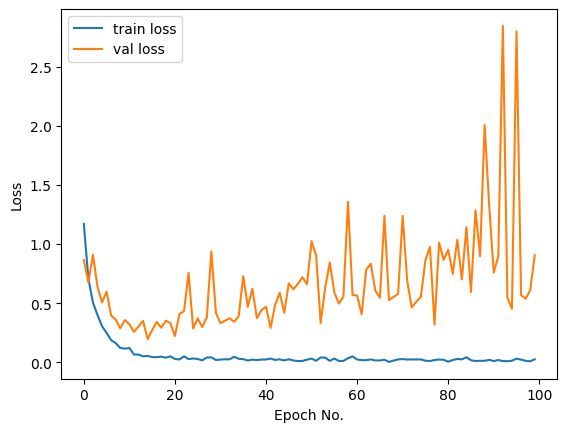

In [19]:
plt.plot(Custom_CNN.history['loss'], label='train loss')
plt.plot(Custom_CNN.history['val_loss'], label='val loss')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

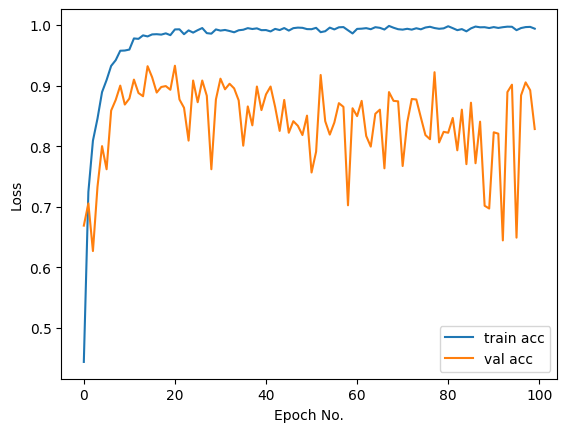

In [20]:
plt.plot(Custom_CNN.history['acc'], label='train acc')
plt.plot(Custom_CNN.history['val_acc'], label='val acc')
plt.xlabel('Epoch No.')
plt.ylabel('Loss')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

41/41 [==============================] - 5s 122ms/step
                       precision    recall  f1-score   support

    giloma (Class 0 )       0.93      0.66      0.77       422
muningioma (Classs 1)       0.48      0.90      0.63       163
   no tumor (class 2)       0.95      0.95      0.95       406
  pituitary (class 3)       0.92      0.86      0.89       320

             accuracy                           0.83      1311
            macro avg       0.82      0.84      0.81      1311
         weighted avg       0.88      0.83      0.84      1311



Text(50.722222222222214, 0.5, 'Actual values')

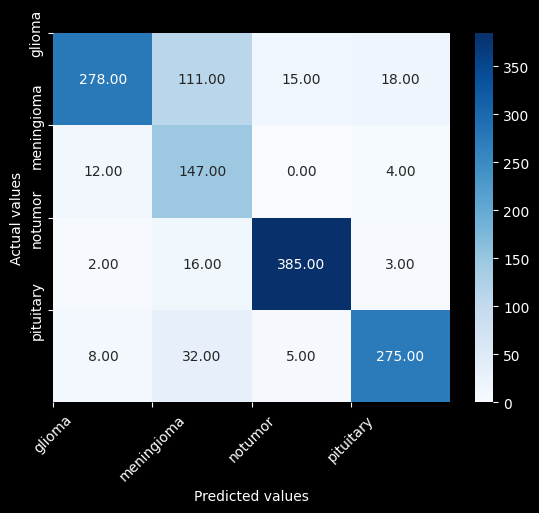

In [21]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
#predict
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)

#get classification repor
print(classification_report(y_pred,y_test,target_names=['giloma (Class 0 )','muningioma (Classs 1)','no tumor (class 2)','pituitary (class 3)']))
with plt.style.context('dark_background'):
    cm=confusion_matrix(y_pred,y_test)
    sns.heatmap(cm,annot=True,cmap=plt.cm.Blues,fmt='.2f',)
    tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels,)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

In [23]:
cm = confusion_matrix(y_pred,y_test)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = np.sum(cm) - (FP + FN + TP)
print(FP,FN,TP,TN)

[ 22 159  20  25] [144  16  21  45] [278 147 385 275] [867 989 885 966]


1/1 [==============================] - 0s 34ms/step


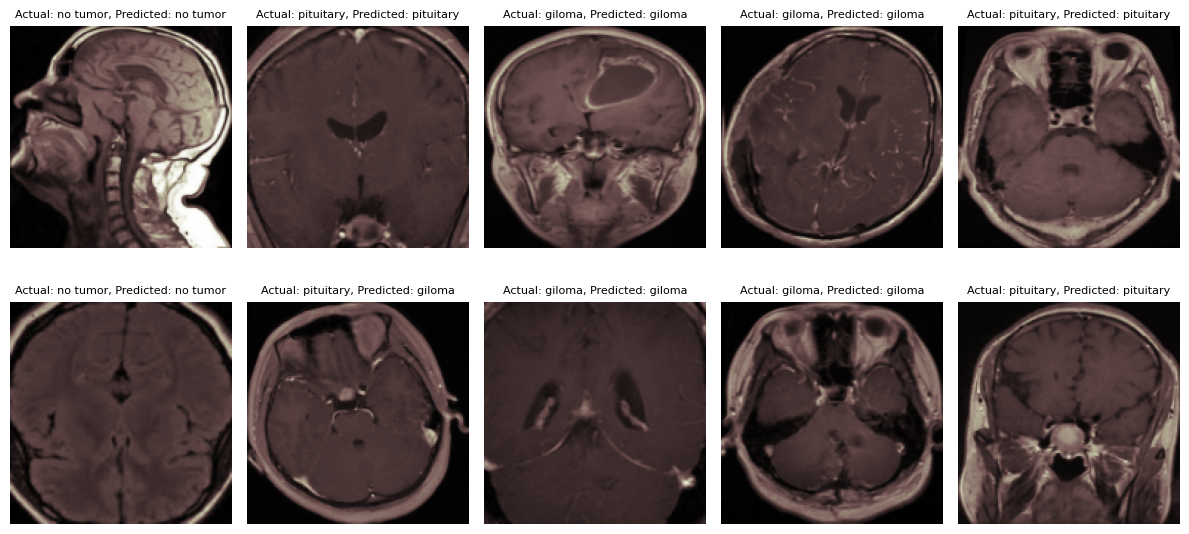

In [39]:
import matplotlib.pyplot as plt

class_names = ['giloma', 'muningioma', 'no tumor', 'pituitary']

random_indices = np.random.choice(len(x_test), size=10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, index in enumerate(random_indices):
    prediction = model.predict(np.expand_dims(x_test[index], axis=0))
    predicted_class = np.argmax(prediction)
    image = x_test[index]
    actual_label = class_names[y_test[index]]
    predicted_label = class_names[predicted_class]
    
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f'Actual: {actual_label}, Predicted: {predicted_label}', fontsize=8, loc='center')
    ax.axis('off')

plt.tight_layout()
plt.show()